---
# AmpliGraph Tutorial 1
---
In this tutorial we will demonstrate how to use the AmpliGraph library. 

Things we will cover:
- Exploring a graph dataset
- Training a graph embeddings model
- Evaluating the graph embeddings model 
- Using link prediction to discover unknown relations
- Extracting embeddings from a model
- Visualizing embeddings using Tensorboard

---

### Requirements:

A python environment (conda, virtualenv) with the AmpliGraph library installed:

    pip install ampligraph numpy pandas 

Additionally, you may want to install matplotlib and networkx to run some graph visualization code:

    pip install matplotlib networkx 

---


## First things first! 
Lets import the required libraries and retrieve some data 

In [1]:
import ampligraph
import numpy as np
import pandas as pd

In this tutorial we're going to use the Nations graph dataset. 

In [2]:

data = dict()
data['train'] = pd.read_csv('./data/nations/train.txt', sep='\t', header=None).values
data['test'] = pd.read_csv('./data/nations/test.txt', sep='\t', header=None).values
data['valid'] = pd.read_csv('./data/nations/valid.txt', sep='\t', header=None).values

# Making a DataFrame of all the sets just to help data exploration. :)
df = pd.DataFrame(np.concatenate([data['train'], data['test'], data['valid']]), columns=['subject', 'predicate', 'object'])


The data is pre-split into train/test/valid sets.

In [42]:
print('Train set size: ', data['train'].shape)
print('Test set size: ', data['test'].shape)
print('Valid set size: ', data['valid'].shape)

Train set size:  (1592, 3)
Test set size:  (201, 3)
Valid set size:  (199, 3)


Each data point is an RDF triple in the form: 

    <subject, predicate, object>


In [38]:
df.head(10)

,subject,predicate,object
0,netherlands,militaryalliance,uk
1,egypt,intergovorgs3,usa
2,jordan,relbooktranslations,usa
3,poland,timesincewar,ussr
4,uk,negativebehavior,ussr
5,poland,relintergovorgs,uk
6,usa,weightedunvote,india
7,china,accusation,india
8,uk,unweightedunvote,egypt
9,poland,embassy,netherlands


These are the subject and object entities in the dataset:

In [4]:
entities = np.concatenate([df['subject'], df['object']])

print(np.unique(entities))

['brazil' 'burma' 'china' 'cuba' 'egypt' 'india' 'indonesia' 'israel'
 'jordan' 'netherlands' 'poland' 'uk' 'usa' 'ussr']


.. and here are the relations that can are defined between them:

In [5]:
relations = df['predicate']

print(relations.unique())

['militaryalliance' 'intergovorgs3' 'relbooktranslations' 'timesincewar'
 'negativebehavior' 'relintergovorgs' 'weightedunvote' 'accusation'
 'unweightedunvote' 'embassy' 'commonbloc1' 'commonbloc2' 'ngoorgs3'
 'exports3' 'economicaid' 'booktranslations' 'relexports' 'intergovorgs'
 'independence' 'reltreaties' 'ngo' 'blockpositionindex' 'relstudents'
 'aidenemy' 'eemigrants' 'officialvisits' 'unoffialacts' 'releconomicaid'
 'commonbloc0' 'expeldiplomats' 'relngo' 'students' 'nonviolentbehavior'
 'reldiplomacy' 'tourism' 'timesinceally' 'conferences' 'relexportbooks'
 'treaties' 'militaryactions' 'exportbooks' 'boycottembargo'
 'negativecomm' 'tourism3' 'reltourism' 'pprotests' 'emigrants3'
 'duration' 'attackembassy' 'dependent' 'violentactions' 'relemigrants'
 'warning' 'lostterritory' 'severdiplomatic']


## Visualizing graph data with NetworkX 

When working with graphs it's often useful to visualize the data. 

Here, we're going to use the excellent NetworkX library to show some of the relations defined between the entities in our data.


C:\Users\nicholas.mccarthy\miniconda3\envs\ampligraph\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


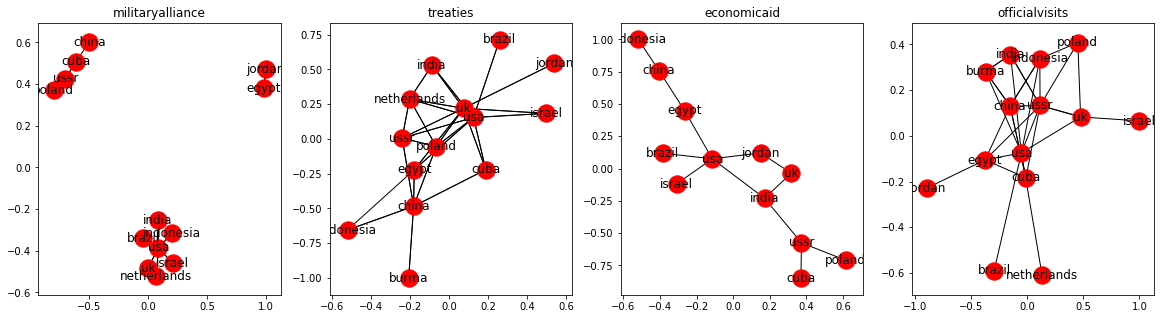

In [6]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for index, relation in enumerate(['militaryalliance', 'treaties', 'economicaid', 'officialvisits']):

    G = nx.MultiGraph()
    for i, row in df.loc[df['predicate'] == relation].iterrows():
        G.add_nodes_from([row[0], row[2]])
        G.add_edge(row[0], row[2], name=row[1])

    axs[index].set_title(relation)
    nx.draw_networkx(G, ax=axs[index])

---
## Selecting a graph embedding model 

AmpliGraph has implemented several Graph embedding models (TransE, ComplEx, DistMult, HolE), but in this tutorial we will use the ComplEx model, so lets import that:

In [6]:
from ampligraph.latent_features import ComplEx

We've run extensive hyperparameter searches to determine the best default values for each model, but lets go through the parameters to understand what's going on:

- ***k*** : the dimensionality of the embedding space
- ***$\eta$*** (eta) : the number of negative, or false triples that must be generated at training runtime for each positive, or true triple
- ***batches_count*** : the number of batches in which the training set is split during the training loop. If you are having into low memory issues than settings this to a higher number may help.
- ***epochs*** : the number of epochs to train the model for.
- ***optimizer*** : the Adam optimizer, with a learning rate of 1e-3 set via the *optimizer_params* kwarg.
- ***loss*** : pairwise loss, with a margin of 0.5 set via the *loss_params* kwarg.
- ***regularizer*** : $L_p$ regularization with $p=2$, i.e. l2 regularization. $\lambda$ = 1e-5, set via the *regularizer_params* kwarg. 

Now we can instantiate the model:


In [84]:
model = ComplEx(batches_count=10, 
                seed=0, 
                epochs=100, 
                k=10, 
                eta=10,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='pairwise', 
                loss_params={'margin':0.5},
                regularizer='LP', 
                regularizer_params={'p':2, 'lambda':1e-5}, 
                verbose=True)

------ Loss-----
2019-04-10 18:23:48,140 - ampligraph.latent_features.loss_functions - INFO - Name:pairwise
Name: pairwise
2019-04-10 18:23:48,142 - ampligraph.latent_features.loss_functions - INFO - Parameters:
Parameters:
2019-04-10 18:23:48,143 - ampligraph.latent_features.loss_functions - INFO - 	eta: 
   eta :  10
2019-04-10 18:23:48,144 - ampligraph.latent_features.loss_functions - INFO - 	margin: 
   margin :  0.5
------ Regularizer-----
2019-04-10 18:23:48,146 - ampligraph.latent_features.regularizers - INFO - ------ Regularizer-----
Name: LP
2019-04-10 18:23:48,147 - ampligraph.latent_features.regularizers - INFO - Name:LP
Parameters:
2019-04-10 18:23:48,148 - ampligraph.latent_features.regularizers - INFO - Parameters:
2019-04-10 18:23:48,148 - ampligraph.latent_features.regularizers - INFO - 	lambda:1e-05

   lambda :  1e-05
2019-04-10 18:23:48,149 - ampligraph.latent_features.regularizers - INFO - 	p:2

   p :  2


---
## Training the graph embeddings model

In this section we'll show you how to train the model.

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to *fit, evaluate, predict* functions. 

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no *negative* statements generated by the corruption procedure are actually positives. This is simply done by concatenating our train, valid and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.  


In [85]:
positives_filter = np.concatenate((data['train'], data['valid'], data['test']))    

We're going to use early stopping to ensure we don't waste our valuable GPU cycles, so let's take a look at some of the parameters:

- ***x_valid*** - specifies our validation set, so that we can test model performance on data we're not training on and stop at a good point
- ***criteria*** - the metric we'll use to measure model performance on the validation set. We specify here the 'hits10' criteria, which measures the amount of times the positive sample is found in the top 10 closest values when performing link prediction #TODO: Check this text
- ***burn_in*** - allows the model to train for a few epochs before early stopping kicks in
- ***check_interval*** - specifies how often the validation set should be evaluated for early stopping. 
- ***stop_interval*** - specifies how many validation set evaluations must be bad for early stopping to kick in. 
- ***x_filter*** - specifies the filter used to filter out the positives (we defined this above)
- ***corruption_entities*** - specifies the corruption strategy. Here we specify 'all' so corruptions are generated using all of the entitites.
- ***corrupt_side*** - specifies which end of the triple should be used for corruptions. Here we specify 's+o', so both subject and object are used for corruptions, but now at the same time.

Based on the burn_in, check_interval and stop_interval values we can see that the model will train for at least **n** epochs, where

    n = burn_in + (stop_interval * check_interval)  

Once you run the next cell the model will train. On the ***Nations*** dataset this shouldn't take too long: on an i7 CPU each epoch was training in at least under a second, up to a top speed of *6.51 epoch/s*. Early stopping was reached at epoch 64, although your mileage may vary.  

In [86]:
# Fit the model on training and validation set
model.fit(data['train'], 
          early_stopping = True,
          early_stopping_params = \
              {
                  'x_valid': data['valid'],    
                  'criteria':'hits10',         
                  'burn_in': 20,                
                  'check_interval':4,          
                  'stop_interval':5,            
                  'x_filter': positives_filter, 
                  'corruption_entities':'all',  
                  'corrupt_side':'s+o'          
              })

    

2019-04-10 18:23:49,524 - ampligraph.latent_features.models - INFO - Using all entities for generation of corruptions


  0%|          | 0/100 [00:00<?, ?epoch/s]

2019-04-10 18:23:51,092 - ampligraph.latent_features.models - INFO - epoch: 1: mean loss:   0.499690


  1%|          | 1/100 [00:00<00:29,  3.31epoch/s]

epoch: 1: mean loss:   0.499690
2019-04-10 18:23:51,134 - ampligraph.latent_features.models - INFO - epoch: 2: mean loss:   0.498971


  1%|          | 1/100 [00:00<00:29,  3.31epoch/s]

epoch: 2: mean loss:   0.498971
2019-04-10 18:23:51,175 - ampligraph.latent_features.models - INFO - epoch: 3: mean loss:   0.497889


  1%|          | 1/100 [00:00<00:29,  3.31epoch/s]

epoch: 3: mean loss:   0.497889
2019-04-10 18:23:51,217 - ampligraph.latent_features.models - INFO - epoch: 4: mean loss:   0.497814


  4%|▍         | 4/100 [00:00<00:21,  4.47epoch/s]

epoch: 4: mean loss:   0.497814
2019-04-10 18:23:51,263 - ampligraph.latent_features.models - INFO - epoch: 5: mean loss:   0.496050


  4%|▍         | 4/100 [00:00<00:21,  4.47epoch/s]

epoch: 5: mean loss:   0.496050
2019-04-10 18:23:51,304 - ampligraph.latent_features.models - INFO - epoch: 6: mean loss:   0.494836


  4%|▍         | 4/100 [00:00<00:21,  4.47epoch/s]

epoch: 6: mean loss:   0.494836
2019-04-10 18:23:51,344 - ampligraph.latent_features.models - INFO - epoch: 7: mean loss:   0.493969


  7%|▋         | 7/100 [00:00<00:15,  5.90epoch/s]

epoch: 7: mean loss:   0.493969
2019-04-10 18:23:51,384 - ampligraph.latent_features.models - INFO - epoch: 8: mean loss:   0.493775


  7%|▋         | 7/100 [00:00<00:15,  5.90epoch/s]

epoch: 8: mean loss:   0.493775
2019-04-10 18:23:51,426 - ampligraph.latent_features.models - INFO - epoch: 9: mean loss:   0.491377


  7%|▋         | 7/100 [00:00<00:15,  5.90epoch/s]

epoch: 9: mean loss:   0.491377
2019-04-10 18:23:51,467 - ampligraph.latent_features.models - INFO - epoch: 10: mean loss:   0.490001


 10%|█         | 10/100 [00:00<00:11,  7.64epoch/s]

epoch: 10: mean loss:   0.490001
2019-04-10 18:23:51,509 - ampligraph.latent_features.models - INFO - epoch: 11: mean loss:   0.491265


 10%|█         | 10/100 [00:00<00:11,  7.64epoch/s]

epoch: 11: mean loss:   0.491265
2019-04-10 18:23:51,550 - ampligraph.latent_features.models - INFO - epoch: 12: mean loss:   0.489148


 10%|█         | 10/100 [00:00<00:11,  7.64epoch/s]

epoch: 12: mean loss:   0.489148
2019-04-10 18:23:51,594 - ampligraph.latent_features.models - INFO - epoch: 13: mean loss:   0.486947


 13%|█▎        | 13/100 [00:00<00:09,  9.58epoch/s]

epoch: 13: mean loss:   0.486947
2019-04-10 18:23:51,637 - ampligraph.latent_features.models - INFO - epoch: 14: mean loss:   0.486682


 13%|█▎        | 13/100 [00:00<00:09,  9.58epoch/s]

epoch: 14: mean loss:   0.486682
2019-04-10 18:23:51,681 - ampligraph.latent_features.models - INFO - epoch: 15: mean loss:   0.484538


 13%|█▎        | 13/100 [00:00<00:09,  9.58epoch/s]

epoch: 15: mean loss:   0.484538
2019-04-10 18:23:51,727 - ampligraph.latent_features.models - INFO - epoch: 16: mean loss:   0.482644


 16%|█▌        | 16/100 [00:00<00:07, 11.58epoch/s]

epoch: 16: mean loss:   0.482644
2019-04-10 18:23:51,774 - ampligraph.latent_features.models - INFO - epoch: 17: mean loss:   0.480879


 16%|█▌        | 16/100 [00:00<00:07, 11.58epoch/s]

epoch: 17: mean loss:   0.480879
2019-04-10 18:23:51,819 - ampligraph.latent_features.models - INFO - epoch: 18: mean loss:   0.479821


 16%|█▌        | 16/100 [00:01<00:07, 11.58epoch/s]

epoch: 18: mean loss:   0.479821
2019-04-10 18:23:51,865 - ampligraph.latent_features.models - INFO - epoch: 19: mean loss:   0.478669


 19%|█▉        | 19/100 [00:01<00:06, 13.46epoch/s]

epoch: 19: mean loss:   0.478669
2019-04-10 18:23:51,913 - ampligraph.latent_features.models - INFO - epoch: 20: mean loss:   0.476785


 19%|█▉        | 19/100 [00:01<00:06, 13.46epoch/s]

epoch: 20: mean loss:   0.476785
2019-04-10 18:23:52,389 - ampligraph.latent_features.models - INFO - Current best:0.7236180904522613
Current best:0.7236180904522613
2019-04-10 18:23:52,390 - ampligraph.latent_features.models - INFO - Current:0.7236180904522613
Current:0.7236180904522613
2019-04-10 18:23:52,434 - ampligraph.latent_features.models - INFO - epoch: 21: mean loss:   0.474924


 19%|█▉        | 19/100 [00:01<00:06, 13.46epoch/s]

epoch: 21: mean loss:   0.474924
2019-04-10 18:23:52,477 - ampligraph.latent_features.models - INFO - epoch: 22: mean loss:   0.474028


 22%|██▏       | 22/100 [00:01<00:08,  8.84epoch/s]

epoch: 22: mean loss:   0.474028
2019-04-10 18:23:52,523 - ampligraph.latent_features.models - INFO - epoch: 23: mean loss:   0.469915


 22%|██▏       | 22/100 [00:01<00:08,  8.84epoch/s]

epoch: 23: mean loss:   0.469915
2019-04-10 18:23:52,567 - ampligraph.latent_features.models - INFO - epoch: 24: mean loss:   0.467427


 22%|██▏       | 22/100 [00:01<00:08,  8.84epoch/s]

epoch: 24: mean loss:   0.467427
2019-04-10 18:23:52,981 - ampligraph.latent_features.models - INFO - Current best:0.7437185929648241
Current best:0.7437185929648241
2019-04-10 18:23:52,982 - ampligraph.latent_features.models - INFO - Current:0.7437185929648241


 24%|██▍       | 24/100 [00:02<00:11,  6.47epoch/s]

Current:0.7437185929648241
2019-04-10 18:23:53,029 - ampligraph.latent_features.models - INFO - epoch: 25: mean loss:   0.466644


 24%|██▍       | 24/100 [00:02<00:11,  6.47epoch/s]

epoch: 25: mean loss:   0.466644
2019-04-10 18:23:53,079 - ampligraph.latent_features.models - INFO - epoch: 26: mean loss:   0.464076


 26%|██▌       | 26/100 [00:02<00:09,  8.12epoch/s]

epoch: 26: mean loss:   0.464076
2019-04-10 18:23:53,127 - ampligraph.latent_features.models - INFO - epoch: 27: mean loss:   0.462090


 26%|██▌       | 26/100 [00:02<00:09,  8.12epoch/s]

epoch: 27: mean loss:   0.462090
2019-04-10 18:23:53,168 - ampligraph.latent_features.models - INFO - epoch: 28: mean loss:   0.456942


 26%|██▌       | 26/100 [00:02<00:09,  8.12epoch/s]

epoch: 28: mean loss:   0.456942
2019-04-10 18:23:53,575 - ampligraph.latent_features.models - INFO - Current best:0.7437185929648241
Current best:0.7437185929648241
2019-04-10 18:23:53,576 - ampligraph.latent_features.models - INFO - Current:0.7437185929648241


 28%|██▊       | 28/100 [00:02<00:11,  6.23epoch/s]

Current:0.7437185929648241
2019-04-10 18:23:53,626 - ampligraph.latent_features.models - INFO - epoch: 29: mean loss:   0.454890


 28%|██▊       | 28/100 [00:02<00:11,  6.23epoch/s]

epoch: 29: mean loss:   0.454890
2019-04-10 18:23:53,673 - ampligraph.latent_features.models - INFO - epoch: 30: mean loss:   0.450216


 28%|██▊       | 28/100 [00:02<00:11,  6.23epoch/s]

epoch: 30: mean loss:   0.450216
2019-04-10 18:23:53,721 - ampligraph.latent_features.models - INFO - epoch: 31: mean loss:   0.447937


 31%|███       | 31/100 [00:02<00:08,  7.87epoch/s]

epoch: 31: mean loss:   0.447937
2019-04-10 18:23:53,769 - ampligraph.latent_features.models - INFO - epoch: 32: mean loss:   0.445705


 31%|███       | 31/100 [00:02<00:08,  7.87epoch/s]

epoch: 32: mean loss:   0.445705
2019-04-10 18:23:54,172 - ampligraph.latent_features.models - INFO - Current best:0.7537688442211056
Current best:0.7537688442211056
2019-04-10 18:23:54,173 - ampligraph.latent_features.models - INFO - Current:0.7537688442211056
Current:0.7537688442211056
2019-04-10 18:23:54,215 - ampligraph.latent_features.models - INFO - epoch: 33: mean loss:   0.441696


 33%|███▎      | 33/100 [00:03<00:10,  6.13epoch/s]

epoch: 33: mean loss:   0.441696
2019-04-10 18:23:54,264 - ampligraph.latent_features.models - INFO - epoch: 34: mean loss:   0.437885


 33%|███▎      | 33/100 [00:03<00:10,  6.13epoch/s]

epoch: 34: mean loss:   0.437885
2019-04-10 18:23:54,309 - ampligraph.latent_features.models - INFO - epoch: 35: mean loss:   0.435203


 33%|███▎      | 33/100 [00:03<00:10,  6.13epoch/s]

epoch: 35: mean loss:   0.435203
2019-04-10 18:23:54,353 - ampligraph.latent_features.models - INFO - epoch: 36: mean loss:   0.430041


 33%|███▎      | 33/100 [00:03<00:10,  6.13epoch/s]

epoch: 36: mean loss:   0.430041
2019-04-10 18:23:54,770 - ampligraph.latent_features.models - INFO - Current best:0.7638190954773869
Current best:0.7638190954773869
2019-04-10 18:23:54,771 - ampligraph.latent_features.models - INFO - Current:0.7638190954773869


 36%|███▌      | 36/100 [00:03<00:10,  5.90epoch/s]

Current:0.7638190954773869
2019-04-10 18:23:54,820 - ampligraph.latent_features.models - INFO - epoch: 37: mean loss:   0.427989


 36%|███▌      | 36/100 [00:04<00:10,  5.90epoch/s]

epoch: 37: mean loss:   0.427989
2019-04-10 18:23:54,861 - ampligraph.latent_features.models - INFO - epoch: 38: mean loss:   0.421776


 36%|███▌      | 36/100 [00:04<00:10,  5.90epoch/s]

epoch: 38: mean loss:   0.421776
2019-04-10 18:23:54,904 - ampligraph.latent_features.models - INFO - epoch: 39: mean loss:   0.419695


 39%|███▉      | 39/100 [00:04<00:08,  7.57epoch/s]

epoch: 39: mean loss:   0.419695
2019-04-10 18:23:54,947 - ampligraph.latent_features.models - INFO - epoch: 40: mean loss:   0.417755


 39%|███▉      | 39/100 [00:04<00:08,  7.57epoch/s]

epoch: 40: mean loss:   0.417755
2019-04-10 18:23:55,352 - ampligraph.latent_features.models - INFO - Current best:0.7738693467336684
Current best:0.7738693467336684
2019-04-10 18:23:55,353 - ampligraph.latent_features.models - INFO - Current:0.7738693467336684
Current:0.7738693467336684
2019-04-10 18:23:55,401 - ampligraph.latent_features.models - INFO - epoch: 41: mean loss:   0.412031


 41%|████      | 41/100 [00:04<00:09,  5.98epoch/s]

epoch: 41: mean loss:   0.412031
2019-04-10 18:23:55,451 - ampligraph.latent_features.models - INFO - epoch: 42: mean loss:   0.410049


 41%|████      | 41/100 [00:04<00:09,  5.98epoch/s]

epoch: 42: mean loss:   0.410049
2019-04-10 18:23:55,494 - ampligraph.latent_features.models - INFO - epoch: 43: mean loss:   0.406345


 41%|████      | 41/100 [00:04<00:09,  5.98epoch/s]

epoch: 43: mean loss:   0.406345
2019-04-10 18:23:55,542 - ampligraph.latent_features.models - INFO - epoch: 44: mean loss:   0.400399


 41%|████      | 41/100 [00:04<00:09,  5.98epoch/s]

epoch: 44: mean loss:   0.400399
2019-04-10 18:23:55,966 - ampligraph.latent_features.models - INFO - Current best:0.7889447236180904
Current best:0.7889447236180904
2019-04-10 18:23:55,967 - ampligraph.latent_features.models - INFO - Current:0.7889447236180904


 44%|████▍     | 44/100 [00:05<00:09,  5.77epoch/s]

Current:0.7889447236180904
2019-04-10 18:23:56,013 - ampligraph.latent_features.models - INFO - epoch: 45: mean loss:   0.394735


 44%|████▍     | 44/100 [00:05<00:09,  5.77epoch/s]

epoch: 45: mean loss:   0.394735
2019-04-10 18:23:56,056 - ampligraph.latent_features.models - INFO - epoch: 46: mean loss:   0.394836


 44%|████▍     | 44/100 [00:05<00:09,  5.77epoch/s]

epoch: 46: mean loss:   0.394836
2019-04-10 18:23:56,105 - ampligraph.latent_features.models - INFO - epoch: 47: mean loss:   0.392859


 47%|████▋     | 47/100 [00:05<00:07,  7.38epoch/s]

epoch: 47: mean loss:   0.392859
2019-04-10 18:23:56,153 - ampligraph.latent_features.models - INFO - epoch: 48: mean loss:   0.389345


 47%|████▋     | 47/100 [00:05<00:07,  7.38epoch/s]

epoch: 48: mean loss:   0.389345
2019-04-10 18:23:56,562 - ampligraph.latent_features.models - INFO - Current best:0.8140703517587939
Current best:0.8140703517587939
2019-04-10 18:23:56,563 - ampligraph.latent_features.models - INFO - Current:0.8140703517587939
Current:0.8140703517587939
2019-04-10 18:23:56,607 - ampligraph.latent_features.models - INFO - epoch: 49: mean loss:   0.381182


 49%|████▉     | 49/100 [00:05<00:08,  5.87epoch/s]

epoch: 49: mean loss:   0.381182
2019-04-10 18:23:56,657 - ampligraph.latent_features.models - INFO - epoch: 50: mean loss:   0.383120


 49%|████▉     | 49/100 [00:05<00:08,  5.87epoch/s]

epoch: 50: mean loss:   0.383120
2019-04-10 18:23:56,704 - ampligraph.latent_features.models - INFO - epoch: 51: mean loss:   0.379908


 49%|████▉     | 49/100 [00:05<00:08,  5.87epoch/s]

epoch: 51: mean loss:   0.379908
2019-04-10 18:23:56,750 - ampligraph.latent_features.models - INFO - epoch: 52: mean loss:   0.378909


 49%|████▉     | 49/100 [00:05<00:08,  5.87epoch/s]

epoch: 52: mean loss:   0.378909
2019-04-10 18:23:57,159 - ampligraph.latent_features.models - INFO - Current best:0.8140703517587939
Current best:0.8140703517587939
2019-04-10 18:23:57,159 - ampligraph.latent_features.models - INFO - Current:0.8090452261306532


 52%|█████▏    | 52/100 [00:06<00:08,  5.75epoch/s]

Current:0.8090452261306532
2019-04-10 18:23:57,201 - ampligraph.latent_features.models - INFO - epoch: 53: mean loss:   0.375017


 52%|█████▏    | 52/100 [00:06<00:08,  5.75epoch/s]

epoch: 53: mean loss:   0.375017
2019-04-10 18:23:57,244 - ampligraph.latent_features.models - INFO - epoch: 54: mean loss:   0.370924


 52%|█████▏    | 52/100 [00:06<00:08,  5.75epoch/s]

epoch: 54: mean loss:   0.370924
2019-04-10 18:23:57,289 - ampligraph.latent_features.models - INFO - epoch: 55: mean loss:   0.368265


 55%|█████▌    | 55/100 [00:06<00:06,  7.41epoch/s]

epoch: 55: mean loss:   0.368265
2019-04-10 18:23:57,334 - ampligraph.latent_features.models - INFO - epoch: 56: mean loss:   0.368875


 55%|█████▌    | 55/100 [00:06<00:06,  7.41epoch/s]

epoch: 56: mean loss:   0.368875
2019-04-10 18:23:57,745 - ampligraph.latent_features.models - INFO - Current best:0.8140703517587939
Current best:0.8140703517587939
2019-04-10 18:23:57,746 - ampligraph.latent_features.models - INFO - Current:0.7989949748743719
Current:0.7989949748743719
2019-04-10 18:23:57,793 - ampligraph.latent_features.models - INFO - epoch: 57: mean loss:   0.362015


 57%|█████▋    | 57/100 [00:07<00:07,  5.88epoch/s]

epoch: 57: mean loss:   0.362015
2019-04-10 18:23:57,842 - ampligraph.latent_features.models - INFO - epoch: 58: mean loss:   0.361557


 57%|█████▋    | 57/100 [00:07<00:07,  5.88epoch/s]

epoch: 58: mean loss:   0.361557
2019-04-10 18:23:57,889 - ampligraph.latent_features.models - INFO - epoch: 59: mean loss:   0.360408


 57%|█████▋    | 57/100 [00:07<00:07,  5.88epoch/s]

epoch: 59: mean loss:   0.360408
2019-04-10 18:23:57,933 - ampligraph.latent_features.models - INFO - epoch: 60: mean loss:   0.358642


 57%|█████▋    | 57/100 [00:07<00:07,  5.88epoch/s]

epoch: 60: mean loss:   0.358642
2019-04-10 18:23:58,333 - ampligraph.latent_features.models - INFO - Current best:0.8140703517587939
Current best:0.8140703517587939
2019-04-10 18:23:58,334 - ampligraph.latent_features.models - INFO - Current:0.7989949748743719


 60%|██████    | 60/100 [00:07<00:06,  5.78epoch/s]

Current:0.7989949748743719
2019-04-10 18:23:58,380 - ampligraph.latent_features.models - INFO - epoch: 61: mean loss:   0.355684


 60%|██████    | 60/100 [00:07<00:06,  5.78epoch/s]

epoch: 61: mean loss:   0.355684
2019-04-10 18:23:58,427 - ampligraph.latent_features.models - INFO - epoch: 62: mean loss:   0.356285


 60%|██████    | 60/100 [00:07<00:06,  5.78epoch/s]

epoch: 62: mean loss:   0.356285
2019-04-10 18:23:58,472 - ampligraph.latent_features.models - INFO - epoch: 63: mean loss:   0.352092


 63%|██████▎   | 63/100 [00:07<00:04,  7.40epoch/s]

epoch: 63: mean loss:   0.352092
2019-04-10 18:23:58,520 - ampligraph.latent_features.models - INFO - epoch: 64: mean loss:   0.351863


 63%|██████▎   | 63/100 [00:07<00:04,  7.40epoch/s]

epoch: 64: mean loss:   0.351863
2019-04-10 18:23:58,939 - ampligraph.latent_features.models - INFO - Current best:0.8140703517587939
Current best:0.8140703517587939
2019-04-10 18:23:58,940 - ampligraph.latent_features.models - INFO - Current:0.8040201005025126
Current:0.8040201005025126
2019-04-10 18:23:58,986 - ampligraph.latent_features.models - INFO - epoch: 65: mean loss:   0.347416


 65%|██████▌   | 65/100 [00:08<00:06,  5.82epoch/s]

epoch: 65: mean loss:   0.347416
2019-04-10 18:23:59,038 - ampligraph.latent_features.models - INFO - epoch: 66: mean loss:   0.349324


 65%|██████▌   | 65/100 [00:08<00:06,  5.82epoch/s]

epoch: 66: mean loss:   0.349324
2019-04-10 18:23:59,086 - ampligraph.latent_features.models - INFO - epoch: 67: mean loss:   0.349854


 65%|██████▌   | 65/100 [00:08<00:06,  5.82epoch/s]

epoch: 67: mean loss:   0.349854
2019-04-10 18:23:59,131 - ampligraph.latent_features.models - INFO - epoch: 68: mean loss:   0.343502


 65%|██████▌   | 65/100 [00:08<00:06,  5.82epoch/s]

epoch: 68: mean loss:   0.343502
2019-04-10 18:23:59,531 - ampligraph.latent_features.models - INFO - Early stopping at epoch:68
Early stopping at epoch:68
2019-04-10 18:23:59,532 - ampligraph.latent_features.models - INFO - Best hits10:   0.814070
Best hits10:   0.814070


---
## Saving and restoring a model

Before we go any further, let's save the model so that we can restore it in future. 

In [98]:
from ampligraph.latent_features import save_model, restore_model

This will save the model in the ampligraph_tutorial directory as *model.pickle*.

In [88]:
save_model(model, './ampligraph_tutorial')

.. we can then delete the model .. 

In [89]:
del model

.. and then restore it from disk! Ta-da! 

In [90]:
model = restore_model('./ampligraph_tutorial/')

------ Loss-----
2019-04-10 18:23:59,601 - ampligraph.latent_features.loss_functions - INFO - Name:pairwise
Name: pairwise
2019-04-10 18:23:59,602 - ampligraph.latent_features.loss_functions - INFO - Parameters:
Parameters:
2019-04-10 18:23:59,603 - ampligraph.latent_features.loss_functions - INFO - 	eta: 
   eta :  10
2019-04-10 18:23:59,604 - ampligraph.latent_features.loss_functions - INFO - 	margin: 
   margin :  0.5
------ Regularizer-----
2019-04-10 18:23:59,605 - ampligraph.latent_features.regularizers - INFO - ------ Regularizer-----
Name: LP
2019-04-10 18:23:59,606 - ampligraph.latent_features.regularizers - INFO - Name:LP
Parameters:
2019-04-10 18:23:59,607 - ampligraph.latent_features.regularizers - INFO - Parameters:
2019-04-10 18:23:59,608 - ampligraph.latent_features.regularizers - INFO - 	lambda:1e-05

   lambda :  1e-05
2019-04-10 18:23:59,608 - ampligraph.latent_features.regularizers - INFO - 	p:2

   p :  2


And let's just double check that the model we restored has been fit:

In [14]:
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

The model is fit!


---
## Evaluating a model

Now it's time to evaluate our model on the test set to see how well it's performing. 

For this we'll use the `evaluate_performance` function. 

In [77]:
from ampligraph.evaluation import evaluate_performance

And let's look at the parameters required:

- ***X*** - the data to evaluate on. We're going to use our test set to evaluate.
- ***model*** - the model we previously trained.
- ***filter_triples*** - will filter out the false negatives generated by the corruption strategy. 
- ***use_default_protocol*** - specifies whether to use the default corruption protocol. If True, then subj and obj are corrupted separately during evaluation.
- ***verbose*** - will give some nice log statements. Let's leave it on for now.

Run the cell below to evaluate the model and obtain ranks for each of the test set triples.

In [78]:
ranks = evaluate_performance(data['test'], 
                             model=model, 
                             filter_triples=positives_filter,
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

100%|██████████| 201/201 [00:00<00:00, 38.85it/s]

2019-04-10 18:23:15,899 - ampligraph.evaluation.protocol - INFO - Returning ranks of positive test triples obtained by corrupting ['s', 'o'].



The ***ranks*** returned by the evaluate_performance function indicate the rank at which the test set triple was found when performing link prediction using the model. 

For example, given the triple:

    <cuba, independence, usa> 
    
The model may return a rank of 2. This tells us that while it's not the highest likelihood true statement (which would be given a rank of 1), it's pretty darn likely.


Let's compute some evaluate metrics and print them out.

We're going to use the mrr_score (mean reciprocal rank) and hits_at_n_score functions. 

- ***mrr_score***:  The function computes the mean of the reciprocal of elements of a vector of rankings ranks.


#TODO: Get the LateX for the equation below

It is formally defined as follows:
MRR=1|Q|∑i=1|Q|1rank(s,p,o)i

where Q
is a set of triples and (s,p,o) is a triple ∈Q.

- ***hits_at_n_score***: The function computes how many elements of a vector of rankings ranks make it to the top n positions.

It is formally defined as follows:
Hits@N=∑i=1|Q|1ifrank(s,p,o)i≤N

where Q
is a set of triples and (s,p,o) is a triple ∈Q.



In [97]:
from ampligraph.evaluation import mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
hits_10 = hits_at_n_score(ranks, n=10)
print("MRR: %f, Hits@10: %f" % (mrr, hits_10))

MRR: 0.545759, Hits@10: 0.975124


---
## Performing link prediction

Link prediction allows us to infer missing links in a graph. This has many real-world use cases, such as predicting connections between people in a social network, interactions between proteins in a biological network, and music recommendation based on prior user taste. 

In our case, we're going to see which of the following statements are more likely to be true:


In [91]:
unseen_triples = np.array([['ussr', 'militaryalliance', 'usa'], 
                           ['usa', 'militaryalliance', 'ussr'], 
                           ['usa', 'boycottembargo', 'cuba'],
                           ['ussr', 'attackembassy', 'cuba'],
                           ['usa', 'militaryalliance', 'cuba'], 
                           ['usa', 'attackembassy', 'burma']]
                         )

Because our dataset here is a very small graph, there aren't actually all that many missing links 

Before predicting, let's make sure that our model wasn't trained on these statements. 

In [92]:
for new_triple in unseen_triples:
    for train_triple in data['train']:
        if np.all(train_triple == new_triple):
            print('Machine learning? More like machine cheating!')

Now lets make our predictions:

In [93]:
predictions = model.predict(unseen_triples)

.. and print them out. 

In [96]:
for triple, y in zip(unseen_triples, predictions):
    print(triple, 'score: %0.2f' % y)

['ussr' 'militaryalliance' 'usa'] score: 0.29
['usa' 'militaryalliance' 'ussr'] score: 0.05
['usa' 'boycottembargo' 'cuba'] score: -0.08
['ussr' 'attackembassy' 'cuba'] score: 0.06
['usa' 'militaryalliance' 'cuba'] score: 0.25
['usa' 'attackembassy' 'burma'] score: -0.13


---
# Comparing entities

Sometimes you may want to compare two specific entities. Here we'll show you how to extract the embeddings for two named entities and calculate the cosine similarity between them.

First, let's take a look at the entities in our model. During training the model maps entities to internal integer IDs, which we can look at by checking the `ent_to_idx` dict in the model. 

In [155]:
print('Model entities:')
for key, val in model.ent_to_idx.items():
    print('ID: %d \t %s ' %(val, key))

Model entities:
ID: 0 	 brazil 
ID: 1 	 burma 
ID: 2 	 china 
ID: 3 	 cuba 
ID: 4 	 egypt 
ID: 5 	 india 
ID: 6 	 indonesia 
ID: 7 	 israel 
ID: 8 	 jordan 
ID: 9 	 netherlands 
ID: 10 	 poland 
ID: 11 	 uk 
ID: 12 	 usa 
ID: 13 	 ussr 


We don't need to worry about these IDs, as we can use the `get_embeddings` function to retrieve embeddings from an entity string (or list of strings).

Let's get the embeddings for '*india*' and '*egypt*' and calculate their similarity:

In [128]:
embeddings = model.get_embeddings(['egypt', 'india'])

We also need to define our `cosine_similarity` function:

In [133]:
cosine_similarity = lambda A, B:  np.dot(A, B) / ( np.linalg.norm(A) * np.linalg.norm(B) )

Now we can see how close '*india*' and '*egypt*' are in the embedding space:

In [140]:
sim = cosine_similarity(embeddings[0], embeddings[1])

print(sim)

0.17321563


Similarly, we can extract the embeddings for a *relation*:

In [156]:
print(model.rel_to_idx.keys())

dict_keys(['accusation', 'aidenemy', 'attackembassy', 'blockpositionindex', 'booktranslations', 'boycottembargo', 'commonbloc0', 'commonbloc1', 'commonbloc2', 'conferences', 'dependent', 'duration', 'economicaid', 'eemigrants', 'embassy', 'emigrants3', 'expeldiplomats', 'exportbooks', 'exports3', 'independence', 'intergovorgs', 'intergovorgs3', 'lostterritory', 'militaryactions', 'militaryalliance', 'negativebehavior', 'negativecomm', 'ngo', 'ngoorgs3', 'nonviolentbehavior', 'officialvisits', 'pprotests', 'relbooktranslations', 'reldiplomacy', 'releconomicaid', 'relemigrants', 'relexportbooks', 'relexports', 'relintergovorgs', 'relngo', 'relstudents', 'reltourism', 'reltreaties', 'severdiplomatic', 'students', 'timesinceally', 'timesincewar', 'tourism', 'tourism3', 'treaties', 'unoffialacts', 'unweightedunvote', 'violentactions', 'warning', 'weightedunvote'])


Relations are also mapped to internal integer IDs, and we can use the same `get_embeddings` function to return them, although we must specify `type='relation'`:

In [157]:
emb_milalliance = model.get_embeddings('militaryalliance', type='relation')
print(emb_milalliance)

[-0.03753308  0.32619956 -0.39504996  0.32349876 -0.23779649 -0.5650244
 -0.15050094 -0.07272594 -0.06668092  0.02771894  0.24203274 -0.16239871
 -0.10952631  0.08926132 -0.13547944  0.10634978  0.05615523 -0.10192978
 -0.30027008  0.08138705]


Once we have these embeddings, we can do some vector algebra to manually perform the link prediction task from above.

Let's calculate the likelihood of the `<usa, militaryalliance, cuba>` triple being true:


In [191]:
emb_usa = model.get_embeddings('usa')
emb_cuba = model.get_embeddings('cuba')

def complex_predict(s, p, o):
    # See Eq. 9 [Trouillon17)
    s_real, s_img = np.split(s, 2)
    p_real, p_img = np.split(p, 2)
    o_real, o_img = np.split(o, 2)
    
    return np.sum(p_real * s_real * o_real) + \
           np.sum(p_real * s_img * o_img) + \
           np.sum(p_img * s_real * o_img) - \
           np.sum(p_img * s_img * o_real)

complex_predict(emb_usa, emb_milalliance, emb_cuba)

0.25062627

Which is the same result as the score output by the models `predict` function above:


---
# Visualizing with Tensorboard projector 

The kind folks at Google have created Tensorboard, which allows us to graph how our model is learning (or .. not :|), peer into the innards of neural networks, and visualize high-dimensional embeddings in the browser.   

Lets import the `create_tensorboard_visualization` function, which simplifies the creation of the files necessary for Tensorboard to display the embeddings.

In [22]:
from ampligraph.latent_features.model_utils import create_tensorboard_visualizations

ImportError: cannot import name 'create_tensorboard_visualizations' from 'ampligraph.latent_features.model_utils' (/opt/anaconda3/envs/jupyterhub/lib/python3.7/site-packages/ampligraph/latent_features/model_utils.py)

And now we'll run the function with our model, specifying the output path:

In [ ]:
create_tensorboard_visualizations(model, './ampligraph_tutorial/visualizations')

If all went well, we should now have a number of files in the *'./ampligraph_tutoria/visualizations/'* directory:

- checkpoint
- metadata.tsv
- projector_config.pbtxt
- .. and a number of graph_embedding.ckpt.* files 

To visualize the embeddings in Tensorboard, run the following from your command line in the *ampligraph_tutorial* directory.

    tensorboard --logdir=./visualizations
    
    
.. and once your browser opens up you should be able to see and explore your embeddings as below. 

![title](tensorboard_graph_example.png)


---
## The End

You made it to the end! Well done!

For more information please visit:

- github.com/Accenture/AmpliGraph (and remember to star the project!) 
- docs.ampligraph.com


---
